In [ ]:
%pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.1 MB/s eta 0:00:00


In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

**Batasan:**

Periode perencanaan diketahui, yaitu 1 periode = 1 hari

Biaya di semua periode diasumsikan konstan dan tidak tergantung pada jumlah pemesanan

Semua demand harus terpenuhi dan tidak diperbolehkan adanya shortage dan backlog

**Indeks:**

T : jumlah periode dalam planning horizon
i  : jenis bahan baku (i = 1,2,3)

t  : periode waktu datang (t = 1,…,T)

**Parameter:**

𝑙_𝑖   =𝑙𝑒𝑎𝑑 𝑡𝑖𝑚𝑒 bahan baku i (3 hari)

𝑐_𝑖   =harga satuan bahan baku i (Rp. 8000, Rp. 7000, Rp. 7300)

𝑜_𝑖   =𝑜𝑟𝑑𝑒𝑟𝑖𝑛𝑔 𝑐𝑜𝑠𝑡 bahan baku i (Rp. 8990)

ℎ_𝑖   =ℎ𝑜𝑙𝑑𝑖𝑛𝑔 𝐶𝑜𝑠𝑡 bahan baku i (Rp. 305.15, Rp. 304.33, Rp. 304.58 per kg)

𝑠𝑠_𝑖𝑡 =𝑠𝑎𝑓𝑒𝑡𝑦 𝑠𝑡𝑜𝑐𝑘 bahan baku i pada periode t (10641.2 kg, 5651.6 kg, 9196.4)

𝑑_𝑖𝑡  =𝑑𝑒𝑚𝑎𝑛𝑑 bahan baku i pada periode t (per 30 hari)

m_i = kapasitas gudang bahan baku (110 ton)

In [ ]:
# 1. Model
model = gp.Model("optimasi bahan baku daur ulang PET")

Restricted license - for non-production use only - expires 2024-10-28


In [ ]:
# 2. Sets
 # 2.1. Periode (hari)
t = 8
periode = range(0, t)

In [ ]:
# 3. Parameter
 # 3.1. Harga bahan baku
harga = [100 for i in periode]

 # 3.2. Holding cost per unit kg per hari penyimpanan
holdingcost = [5 for i in periode]

 # 3.3. Ordering cost per satu kali pesan
orderingcost = [5000 for i in periode]

 # 3.4. Demand per hari (dapat berupa target produksi atau forecast permintaan harian)
demand = [400, 400, 800, 800, 1200, 1200, 1200, 1200]

Variabel Keputusan:

𝑌_𝑖𝑡𝑡′={1,0}−variabel biner

𝑄_𝑖𝑡𝑡′=jumlah bahan baku i yang dipesan pada t′ dan datang pada t

𝑋_𝑖𝑡=level persediaan awal bahan baku i pada periode t


M     = maximum demand amount (big-M value)

In [ ]:
# 4. Variabel
 # 4.1. Kuantitas pesan
kuantitas = model.addVars(t, name="kuantitas", vtype=GRB.INTEGER)

 # 4.2. Inventory (jumlah per hari)
inventory = model.addVars(t + 1, name="inventory", vtype=GRB.INTEGER)

 # 4.3. Keputusan order (pesan = 1 / tidak pesan = 0)
order = model.addVars(t, name="order", vtype=GRB.BINARY)

 # 4.4. Kapasitas gudang (True - tidak ada stock di luar gudang, False - stock di luar)
capacitated = False
if capacitated:
	M = [7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000]
else:
	M = model.addVars(t, name="M", vtype=GRB.INTEGER)

Fungsi Tujuan:

Meminimalkan total biaya persediaan bahan baku gudang yang terdiri dari dua komponen biaya, yaitu biaya pesan (ordering cost) dan biaya simpan (holding cost):

𝑀𝑖𝑛 𝑍=𝑂𝑟𝑑𝑒𝑟𝑖𝑛𝑔 𝐶𝑜𝑠𝑡+𝐻𝑜𝑙𝑑𝑖𝑛𝑔 𝐶𝑜𝑠𝑡


In [ ]:
# 5. Fungsi tujuan
model.setObjective(gp.quicksum(harga[i] * kuantitas[i] + orderingcost[i] * order[i] + holdingcost[i] * inventory[i] for i in periode), GRB.MINIMIZE)

Fungsi Kendala:
1. Memastikan total pemesanan bahan baku pada periode sebelumnya memenuhi demand dengan mendefinisikan nilai level persediaan awal (𝑋_(𝑖𝑡))

2. Memastikan persediaan awal tidak kurang dari jumlah safety stock yang telah ditentukan

3. Mendefinisikan keputusan 𝑌_(𝑖𝑡𝑡′)  bergantung pada 𝑄_(𝑖𝑡𝑡'). Untuk memenuhi hubungan antara 𝑌_(𝑖𝑡𝑡')  dan 𝑄_(𝑖𝑡𝑡'), diperlukan angka positif (𝑀) yang sangat besar

4. Mendefinisikan nilai M sebagai maksimum dari jumlah demand tiap bahan baku selama periode perencanaan dan keputusan biner 𝑌_𝑖𝑡𝑡′  

5. Mendefinisikan variabel keputusan adalah non negatif


In [ ]:
# 6. Constraints (c)
 # 6.1. Inventory memenuhi demand
for i in range(1, t+1):
    model.addConstr((inventory[i] == inventory[i-1] + kuantitas[i-1] - demand[i-1]), "c1")

 # 6.2. Inventory awal
model.addConstr(inventory[0] == 200, "c2")

 # 6.3. Inventory bahan baku lebih dari safety stock
model.addConstr(inventory[t] == 0, "c3")

 # 6.4. Hubungan kuantitas pesan dan waktu pesan memenuhi persamaan dengan Big M-value
for i in periode:
    model.addConstr((kuantitas[i] <= M[i]*order[i]), "c4")

 # 6.5. Non-negatif
for i in periode:
    model.addConstr((order[i] >= 0), "c5")
    model.addConstr((kuantitas[i] >= 0), "c6")
    model.addConstr((inventory[i] >= 0), "c7")
    model.addConstr((M[i] >= 0), "c8");

In [ ]:
# 7. Optimasi
model.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 42 rows, 33 columns and 58 nonzeros
Model fingerprint: 0x95569218
Model has 8 quadratic constraints
Variable types: 0 continuous, 33 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [5e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 1e+03]
Presolve removed 36 rows and 4 columns
Presolve time: 0.00s
Presolved: 30 rows, 53 columns, 74 nonzeros
Presolved model has 16 SOS constraint(s)
Variable types: 0 continuous, 53 integer (16 binary)
Found heuristic solution: objective 860000.00000
Found heuristic solution: objective 831000.00000
Found heuristic solution: objective 823000.00000

Root relaxation: objective 7.180501e+05,

**Analisis**

In [ ]:
# 8. Visualisasi hasil
for v in model.getVars():

	if v.varName.startswith("k"):
		print("Order {} kg bahan baku pada periode {}".format(v.x, v.varName[9:]))

print("--------------------------------")
print("Total biaya persediaan: Rp. {}".format(model.objVal))

Order 600.0 kg bahan baku pada periode [0]
Order 0.0 kg bahan baku pada periode [1]
Order 1600.0 kg bahan baku pada periode [2]
Order 0.0 kg bahan baku pada periode [3]
Order 1200.0 kg bahan baku pada periode [4]
Order 1200.0 kg bahan baku pada periode [5]
Order 1200.0 kg bahan baku pada periode [6]
Order 1200.0 kg bahan baku pada periode [7]
--------------------------------
Total biaya persediaan: Rp. 737000.0


In [ ]:
kolom_order = pd.DataFrame(columns=["Order"])
for o in order.values():
  kolom_order = kolom_order.append({"Order": o.X}, ignore_index=True)

kolom_quantity = pd.DataFrame(columns=["Quantity"])
for q in kuantitas.values():
  kolom_quantity = kolom_quantity.append({"Quantity": q.X}, ignore_index=True)

kolom_inventory = pd.DataFrame(columns=["Inventory"])
for i in inventory.values():
  kolom_inventory = kolom_inventory.append({"Inventory": i.X}, ignore_index=True)
kolom_inventory = kolom_inventory.drop(labels=t, axis=0)

kolom_demand = pd.DataFrame(demand, columns = ["Demand"])

table = pd.concat([kolom_order, kolom_quantity, kolom_inventory, kolom_demand], axis='columns')
table

<ipython-input-21-1ba78b7ccb62>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  kolom_order = kolom_order.append({"Order": o.X}, ignore_index=True)
<ipython-input-21-1ba78b7ccb62>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  kolom_order = kolom_order.append({"Order": o.X}, ignore_index=True)
<ipython-input-21-1ba78b7ccb62>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  kolom_order = kolom_order.append({"Order": o.X}, ignore_index=True)
<ipython-input-21-1ba78b7ccb62>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  kolom_order = kolom_order.append({"Order": o.X}, ignore_index=True)
<ipython-input-21-1ba78b7ccb62>:3: FutureWarning

,Order,Quantity,Inventory,Demand
0,1.0,600.0,200.0,400
1,0.0,0.0,400.0,400
2,1.0,1600.0,0.0,800
3,0.0,0.0,800.0,800
4,1.0,1200.0,-0.0,1200
5,1.0,1200.0,-0.0,1200
6,1.0,1200.0,-0.0,1200
7,1.0,1200.0,0.0,1200


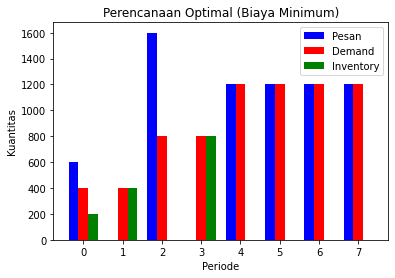

In [ ]:
ind = np.arange(t)
width = 0.25

xvals = table.Quantity
bar1 = plt.bar(ind, xvals, width, color = 'b')

yvals = table.Demand
bar2 = plt.bar(ind+width, yvals, width, color='r')

zvals = table.Inventory
bar3 = plt.bar(ind+width*2, zvals, width, color = 'g')

plt.xlabel("Periode")
plt.ylabel('Kuantitas')
plt.title("Perencanaan Optimal (Biaya Minimum)")

plt.xticks(ind+width,ind)
plt.legend((bar1, bar2, bar3), ('Pesan', 'Demand', 'Inventory'))
plt.show()

In [ ]:
# 9. Analisis
status = model.status
if status == GRB.Status.OPTIMAL:
    print('[model sudah optimal]')
if status == GRB.Status.INF_OR_UNBD or status == GRB.Status.INFEASIBLE  or status == GRB.Status.UNBOUNDED:
    print('[model infeasible atau unbounded]')
if status != GRB.Status.OPTIMAL:
    print('Optimasi belum optimal')

[model sudah optimal]


Output Solution

In [ ]:
#10. Download
m.write("perencanaan-bahan-baku-output.sol")